# BERT model constructed with EA data

2020/11/27

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi


in this module, we use EA data to train a bert model and test 2400 covid data on it


In [ ]:
source_folder = 'Data'
destination_folder = 'Model'

In [ ]:
pip install emoji

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install transformers

In [ ]:
import pandas as pd
EA_data = pd.read_csv('/content/drive/My Drive/hs_AsianPrejudice_20kdataset_cleaned_anonymized.tsv',sep = '\t', encoding = "ISO-8859-1")

In [ ]:
EA_data.head()

,id,annot1,annot2,expert,text,text.clean,annot1.name,annot2.name,expert.name,target.annot1.clean,target.annot2.clean,hostile.threatening,hostile.dehumanization,hostile.interpersonal,COVID relevant,EA relevant,hashtags.annotator1,hashtags.annotator2,hashtags.decision,East Asia,China,Hong Kong,Japan,Korea,Singapore,Taiwan
0,idstr_1212372663416639488,none_of_the_above,none_of_the_above,none_of_the_above,@CNN No doubt a ChiNa female. #shameonchina #B...,@cnn no doubt a china female. HASHTAG_EASTASIA...,annotator_GNZuCtwed3,annotator_gbEGjSAk6r,expert_GNZuCtwed3,NaN,NaN,NaN,NaN,NaN,no_no,yes_yes,hashtags_not_used_at_all_to_identify_themes,hashtags_not_used_at_all_to_identify_themes,agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,idstr_1212374922993053696,none_of_the_above,none_of_the_above,none_of_the_above,@KongTsungGan The #HongKongPoliceBrutality is ...,@kongtsunggan the HASHTAG_EASTASIA is happenin...,annotator_CAgNlUizNm,annotator_cYKSVBW4HD,expert_GNZuCtwed3,NaN,NaN,NaN,NaN,NaN,no_yes,yes_yes,hashtags_not_used_at_all_to_identify_themes,hashtags_only_used_to_identify_covid_relevance,disagree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,idstr_1213452156251987973,none_of_the_above,none_of_the_above,none_of_the_above,Afraid. #ChinaPneumonia,afraid. #HASHTAG,annotator_vDe7GN0NrL,annotator_HtRmsP3KiK,expert_CAgNlUizNm,NaN,NaN,NaN,NaN,NaN,no_no,no_no,hashtags_not_used_at_all_to_identify_themes,hashtags_not_used_at_all_to_identify_themes,agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,idstr_1213471445294075909,none_of_the_above,none_of_the_above,none_of_the_above,RT @shapponeko @Mugisalty @CatBus2D everybody ...,rt @shapponeko @mugisalty @catbus2d everybody ...,annotator_TbUBpfn6iP,annotator_dqrONtdjbt,expert_GNZuCtwed3,NaN,NaN,NaN,NaN,NaN,no_yes,no_no,hashtags_not_used_at_all_to_identify_themes,hashtags_not_used_at_all_to_identify_themes,agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,idstr_1213494381073711105,entity_directed_hostility,entity_directed_hostility,entity_directed_hostility,RT @JAbbott45624607 @annie_sparrow This makes ...,rt @jabbott45624607 @annie_sparrow this makes ...,annotator_oemYWm1Tjg,annotator_IBsVsBliwX,expert_GNZuCtwed3,China,China,twoAnnotations_NoNo,twoAnnotations_NoNo,twoAnnotations_NoNo,yes_yes,yes_yes,hashtags_not_used_at_all_to_identify_themes,hashtags_only_used_to_identify_covid_relevance,disagree,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# types of label
ap = EA_data.groupby(by=['expert'])
ap.size()

expert
counter_speech                         116
discussion_of_eastasian_prejudice     1029
entity_directed_criticism             1433
entity_directed_hostility             3898
none_of_the_above                    13524
dtype: int64

In [ ]:
from tqdm import tqdm
relevant1 = []
relevant2 = []
for i in tqdm(EA_data['hashtags.annotator1']):
    if i == 'hashtags_not_used_at_all_to_identify_themes':
        relevant1.append(0)
    else:
        relevant1.append(1)
for i in tqdm(EA_data['hashtags.annotator2']):
    if i == 'hashtags_not_used_at_all_to_identify_themes':
        relevant2.append(0)
    else:
        relevant2.append(1)

100%|██████████| 20000/20000 [00:00<00:00, 1915907.18it/s]


In [ ]:
final_decision = []
for i in range(len(relevant1)):
    sum_temp = relevant1[i] + relevant2[i]
    if sum_temp > 1:
        final_decision.append(1)
    else:
        final_decision.append(0)


In [ ]:
print("Tag keep ratio is:",final_decision.count(1)/len(final_decision))

Tag keep ratio is: 0.3807


In [ ]:
# keep labels and text.clean
new_EA = EA_data[['text.clean', 'expert']]

In [ ]:
new_EA.head()

,text.clean,expert
0,@cnn no doubt a china female. HASHTAG_EASTASIA...,none_of_the_above
1,@kongtsunggan the HASHTAG_EASTASIA is happenin...,none_of_the_above
2,afraid. #HASHTAG,none_of_the_above
3,rt @shapponeko @mugisalty @catbus2d everybody ...,none_of_the_above
4,rt @jabbott45624607 @annie_sparrow this makes ...,entity_directed_hostility


In [ ]:
import re
from tqdm import tqdm
import emoji

class Word_Preprocessing():
    def eliminate_url(self,df,target):
        print('Start eliminate url: : )')
        df_temp = df
        target_column_name = target
        text = df_temp[target_column_name]
        for i in tqdm(text):
            urls = re.findall(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', i)
            for i in urls:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def eliminate_username(self,df,target):
        print('Start eliminate username: : )')
        df_temp = df
        target_column_name = target
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'@\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
     
    
    def convert_abbreviation(self, df, target):
        df_temp = df
        target_column_name = target
        am = "'m"
        are = "'re"
        have = "'ve"
        not_ = "n't"
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(am, " am"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(are, "  are"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(have, " have"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(not_, " not"))
        return df_temp
    
    
    def final_check(self,df,target):
        print('Start Final check: ')
        df_temp = df
        target_column_name = target
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x:re.sub(r'[^A-Za-z0-9 ]+', ' ', x).lower())
        return df_temp
            
    def eliminate_symbol(self,df,target):
        print('Start eliminate symbol: : )')
        df_temp = df
        target_column_name = target
        symbol_list = [',',"'",'!','@','$','%','^','&','*','(',')','-','+','?','>','<','=','.',':',';','  ','  ','   ','    ','      ','      ','  ']
        for i in tqdm(symbol_list):
            df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ' '))
        return df_temp
    
    def process_all(self, df,target):
        df_temp = df
        target_column_name = target
        df_fresh = self.convert_abbreviation(df_temp,target_column_name)
        df_remove_url = self.eliminate_url(df_fresh,target_column_name)
        df_remove_username = self.eliminate_username(df_remove_url, target_column_name)
        df_remove_symbol = self.eliminate_symbol(df_remove_username, target_column_name)
        df_final_check = self.final_check(df_remove_symbol, target_column_name)
        print("finished!!")
        return df_final_check

In [ ]:
processor = Word_Preprocessing()

In [ ]:
new_EA = processor.process_all(new_EA, 'text.clean')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Start eliminate url: : )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 15/20000 [00:00<02:28, 134.86it/s]

Start eliminate username: : )


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 48%|████▊     | 13/27 [00:00<00:00, 123.83it/s]

Start eliminate symbol: : )


100%|██████████| 27/27 [00:00<00:00, 101.49it/s]


Start Final check: 
finished!!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
[print(new_EA['text.clean'][i],'------') for i in range(10)][0]

 no doubt a china female hashtag eastasia  hashtag ------
 the hashtag eastasia is happening behind the live stream they are cooperating with the ccp hashtag eastasia  hashtag ------
afraid  hashtag ------
rt everybody should wear masks  hashtag ------
rt this makes me remember the sad days in 2003 china covered up the sars situation and allowed it to spread to hk causing 299 dead and many suffered stop the hashtag eastasia virus from spreading  ------
 thats how sars started in hong kong in 2003 mainland chinese government tried to cover things up until its broke out in hong kong hundreds of hong kong citizens and medics were dead due to no cure at early stage of eruption  hashtag ------
 before you wear n95 masks you should look into getting a fit test because unlike surgical masks one size does not fit all for n95 masks having best fit n95 for your face will ensure a good face seal for protection  hashtag hashtag eastasia virus  ------
please wear a mask when you come to hong kong  

In [ ]:
new_EA['text.clean'] = new_EA['text.clean'].apply(lambda x: x.replace('hashtag', ""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
new_EA['text.clean'] = new_EA['text.clean'].apply(lambda x: x.replace('rt', ""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
[print(new_EA['text.clean'][i],'------') for i in range(10)][0]

 no doubt a china female  eastasia   ------
 the  eastasia is happening behind the live stream they are cooperating with the ccp  eastasia   ------
afraid   ------
 everybody should wear masks   ------
 this makes me remember the sad days in 2003 china covered up the sars situation and allowed it to spread to hk causing 299 dead and many suffered stop the  eastasia virus from spreading  ------
 thats how sars staed in hong kong in 2003 mainland chinese government tried to cover things up until its broke out in hong kong hundreds of hong kong citizens and medics were dead due to no cure at early stage of eruption   ------
 before you wear n95 masks you should look into getting a fit test because unlike surgical masks one size does not fit all for n95 masks having best fit n95 for your face will ensure a good face seal for protection    eastasia virus  ------
please wear a mask when you come to hong kong         ------
hongkongers pls protect ourselves   ------
 we call it  chinese pneum

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'length')

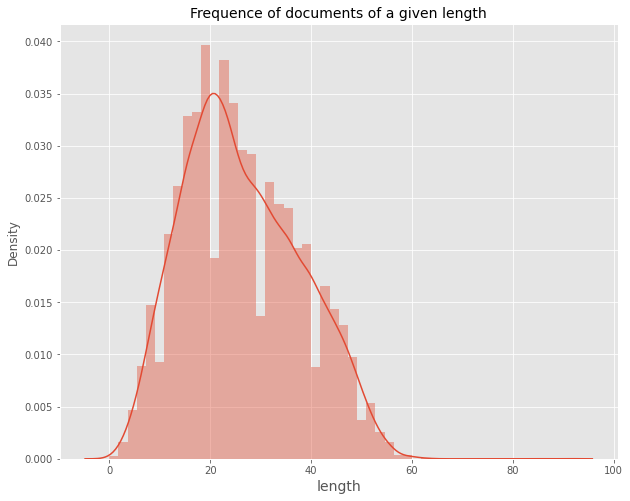

In [ ]:
# get data distributions
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
new_EA['length'] = new_EA['text.clean'].apply(lambda x: len(x.split()))
sns.distplot(new_EA[new_EA['length'] < 150]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [ ]:
new_EA = new_EA.drop(columns=['length'])

## Merge labels ( hostility and criticism VS others)

In [ ]:
mixed_label = []
for i in tqdm(new_EA['expert']):
    if i == 'counter_speech':
        mixed_label.append('0')
    elif i == 'discussion_of_eastasian_prejudice':
        mixed_label.append('0')
    elif i == 'none_of_the_above':
        mixed_label.append('0')
    else:
        mixed_label.append('1')

100%|██████████| 20000/20000 [00:00<00:00, 1600329.66it/s]


In [ ]:
# assign new labels columns into original table
new_EA['expert'] = mixed_label

In [ ]:
new_EA.head()

,text.clean,expert
0,no doubt a china female eastasia,0
1,the eastasia is happening behind the live st...,0
2,afraid,0
3,everybody should wear masks,0
4,this makes me remember the sad days in 2003 c...,1


# model build 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import transformers
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Data split

In [ ]:
new_EA.rename(columns={ new_EA.columns[0]: "text" }, inplace=True)

In [ ]:
new_EA.head()

,text,expert
0,no doubt a china female eastasia,0
1,the eastasia is happening behind the live st...,0
2,afraid,0
3,everybody should wear masks,0
4,this makes me remember the sad days in 2003 c...,1


In [ ]:
text = new_EA['text']
label = new_EA['expert']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=42)

In [ ]:
x_test, x_valid, y_text, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [ ]:
def pack_data(text, label, name):
    EA = {'text':text,'hate':label}
    EA_final = pd.DataFrame(EA)
    file_name = name +'.csv'
    EA_final.to_csv(file_name,index=False,header=True)

In [ ]:
pack_data(x_train, y_train, 'Data/EAtrain')
pack_data(x_test, y_text, 'Data/EAtest')
pack_data(x_valid, y_valid, 'Data/EAvalid')

In [ ]:
# Sections of config
# Defining some key variables that will be used later on in the training
MAX_LEN = 80
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
LEARNING_RATE = 1e-5

In [ ]:
# Model parameter
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('expert', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='EAtrain.csv', validation='EAvalid.csv',
                                           test='EAtest.csv', format='CSV', fields=fields, skip_header=True)


train_iter = BucketIterator(train, batch_size=8, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=8, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=8, device=device, train=False, shuffle=False, sort=False)

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        

        return loss, text_fea

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0 
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        batch_no = 1
        for (text, expert), _ in train_loader:
            expert = expert.type(torch.LongTensor)           
            expert = expert.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, expert)
            loss, _ = output
            print('batch_no [{}/{}]:'.format(batch_no, int(len(x_train)/16)),'training_loss:',loss)
            batch_no+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, expert), _ in valid_loader:
                        expert = expert.type(torch.LongTensor)           
                        expert = expert.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, expert)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
from transformers import AdamW
model = BERT().to(device)
no_decay = ['bias', 'LayerNorm.weight']    
optimizer_grouped_parameters = [
{'params': [p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Streaming output truncated to the last 5000 lines.
batch_no [1008/1000]: training_loss: tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1009/1000]: training_loss: tensor(0.0087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1010/1000]: training_loss: tensor(0.1362, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1011/1000]: training_loss: tensor(0.0285, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1012/1000]: training_loss: tensor(0.1996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1013/1000]: training_loss: tensor(0.0556, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1014/1000]: training_loss: tensor(0.1355, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1015/1000]: training_loss: tensor(0.3927, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1016/1000]: training_loss: tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1017/1000]: training_loss: tensor(0.0322, device='cuda:0', grad_fn=<NllLoss

Model loaded from <== Model/metrics.pt


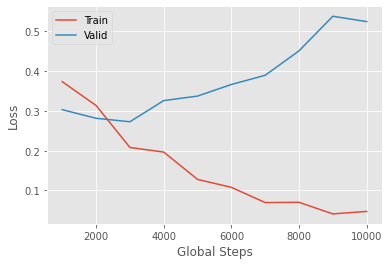

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
from sklearn.metrics import roc_curve
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (comment,toxicity ), _ in test_loader:

                comment = comment.type(torch.LongTensor)           
                comment = comment.to(device)
                toxicity = toxicity.type(torch.LongTensor)  
                toxicity = toxicity.to(device)
                output = model(comment, toxicity)

                _, output = output
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(toxicity.tolist())
    return y_true, y_pred,y_prob    

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

y_true, y_pred,y_prob = evaluate(best_model, test_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model/model.pt


In [ ]:
label_true = []
for i in y_true:
    if i == 1:
        label_true.append([1,0])
    else:
        label_true.append([0,1])

In [ ]:
y_prob_final = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempA/(tempA+tempB))

Classification Report:
              precision    recall  f1-score   support

           1     0.7573    0.8824    0.8151       527
           0     0.9553    0.8988    0.9262      1473

    accuracy                         0.8945      2000
   macro avg     0.8563    0.8906    0.8706      2000
weighted avg     0.9031    0.8945    0.8969      2000



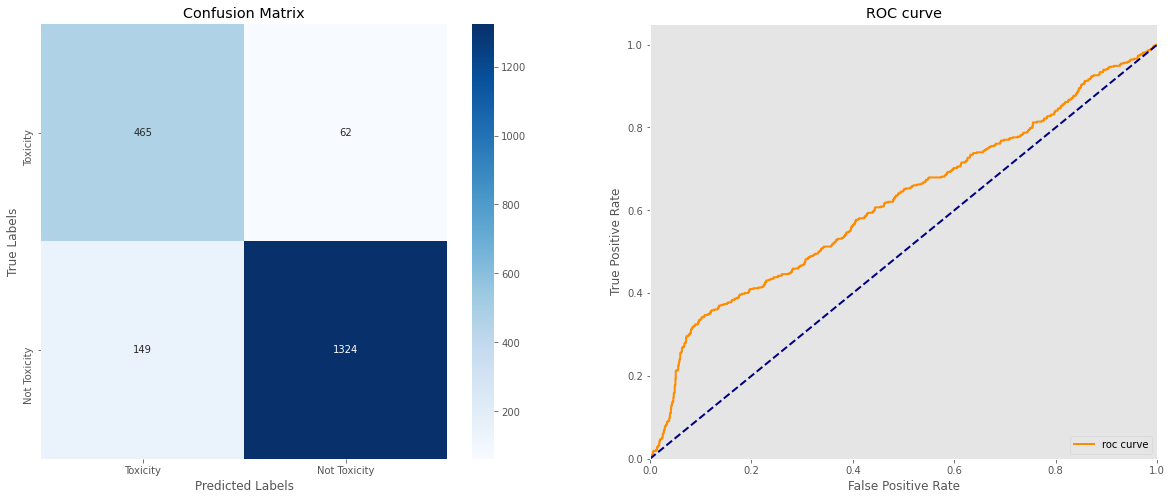

auc score: 0.8905994169561918


In [ ]:
# test data
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxicity', 'Not Toxicity'])
ax.yaxis.set_ticklabels(['Toxicity', 'Not Toxicity'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# auc score
print('auc score:', roc_auc_score(y_true, y_pred))

## 2400 test

In [ ]:
test_data2400 = pd.read_csv('Data/test5.csv',sep=',',encoding = "ISO-8859-1")

In [ ]:
test_data2400.head()

,comment,attack
0,fucking piece of shit your whole community is...,1.0
1,im not being funny but coronavirus in china ir...,0.0
2,got on the victoria line today to seven sister...,1.0
3,it s appalling that the media amp libtards bit...,1.0
4,dude fuck the chinese man fuck em and if you t...,1.0


In [ ]:
test_data2400['attack'] = [int(i) for i in test_data2400['attack']]

In [ ]:
# Model parameter
MAX_SEQ_LEN = 80
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('hate', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='EAtrain.csv', validation='EAvalid.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)

test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
y_true, y_pred,y_prob = evaluate(best_model, test_iter)

In [ ]:
label_true = []
for i in y_true:
    if i == 1:
        label_true.append([1,0])
    else:
        label_true.append([0,1])

In [ ]:
y_prob_final = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempA/(tempA+tempB))

Classification Report:
              precision    recall  f1-score   support

           1     0.5780    0.7920    0.6683       678
           0     0.8986    0.7611    0.8242      1641

    accuracy                         0.7702      2319
   macro avg     0.7383    0.7766    0.7462      2319
weighted avg     0.8049    0.7702    0.7786      2319



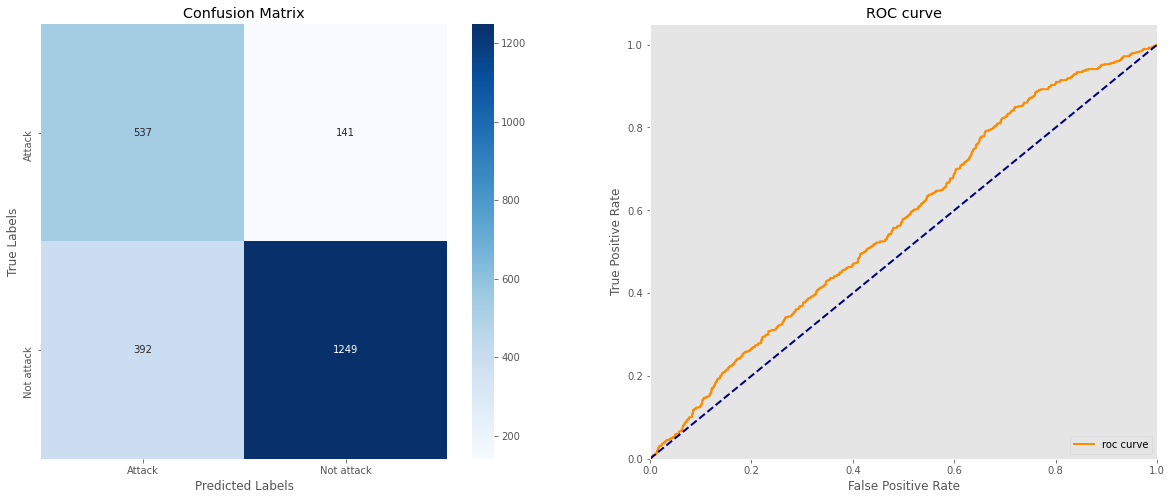

auc score: 0.7765783328749468


In [ ]:
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# auc score
print('auc score:', roc_auc_score(y_true, y_pred))